tensor([499, 249,   5,   4,   2,   2,   2,   2,   2,   1], dtype=torch.int32)
tensor([1.8418e-04, 2.3307e-01, 5.2586e-01, 1.0120e+00, 2.3159e+00, 4.9986e+02,
        2.5780e+00, 1.2639e+00, 7.9051e-01, 5.2381e-01, 3.3533e-01, 1.8070e-01,
        3.7786e-02, 1.0875e-01, 2.7356e-01, 4.7768e-01, 7.5821e-01, 1.1983e+00,
        2.0426e+00, 4.4919e+00, 2.4944e+02, 5.4790e+00, 2.8855e+00, 2.0237e+00,
        1.5889e+00, 1.3246e+00, 1.1456e+00, 1.0156e+00, 9.1625e-01, 8.3768e-01,
        7.7362e-01, 7.2006e-01, 6.7476e-01, 6.3571e-01, 6.0166e-01, 5.7163e-01,
        5.4492e-01, 5.2098e-01, 4.9935e-01, 4.7971e-01, 4.6175e-01, 4.4527e-01,
        4.3011e-01, 4.1609e-01, 4.0301e-01, 3.9087e-01, 3.7952e-01, 3.6888e-01,
        3.5890e-01, 3.4953e-01, 3.4062e-01, 3.3222e-01, 3.2428e-01, 3.1674e-01,
        3.0962e-01, 3.0278e-01, 2.9627e-01, 2.9008e-01, 2.8417e-01, 2.7847e-01,
        2.7311e-01, 2.6789e-01, 2.6291e-01, 2.5814e-01, 2.5355e-01, 2.4910e-01,
        2.4483e-01, 2.4072e-01, 2.3678e-01

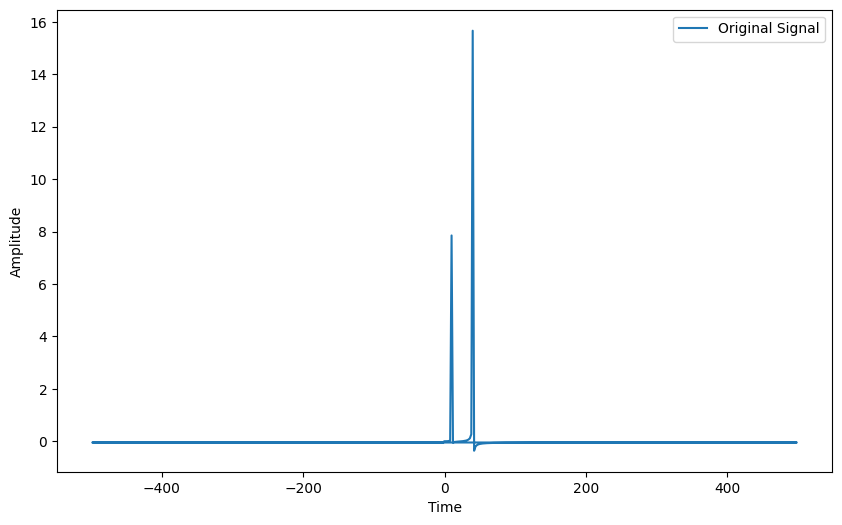

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
from torchvision import transforms
import numpy as np
from fast_hadamard_transform import hadamard_transform

# Create a signal
t = torch.linspace(0, 1, 1000)
x = torch.sin(2 * torch.pi * 5 * t) + 0.5 * torch.sin(2 * torch.pi * 20 * t)
 
# Compute the FFT
X = torch.fft.rfft(x)

energy = X.abs()
idx, val = energy.topk(10)
print(idx.type(torch.int))
print(X.abs())
 
# Create a low-pass filter
N = len(x) // 2 + 1
frequencies = torch.fft.fftfreq(N, t[1] - t[0])
 
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(frequencies, X.real, label='Original Signal')
# plt.plot(t, x_filtered, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()

        self.embed_dim = embed_dim


        self.patcher_conv = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
        self.patcher_conv.weight.data.fill_(1.0)
        self.patcher_conv.bias.data.fill_(1.0)
        self.patcher = nn.Sequential(
            self.patcher_conv,
            nn.Flatten(2)  # [B, E, N]
        )

        # FIXED: correct CLS token shape
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.position_embeddings = nn.Parameter(
            torch.randn(1, num_patches + 1, embed_dim)
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # if self.training:
        #    x = random_mask_pixels_batch(x, 200)

        B = x.shape[0]

        x = self.patcher(x)           # [B, E, N]
        x = x.permute(0, 2, 1)        # [B, N, E]

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        x = x + self.position_embeddings
        x = self.dropout(x)

        return x



torch.Size([65, 256])


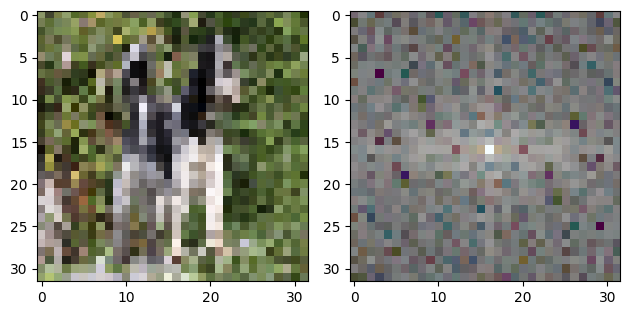

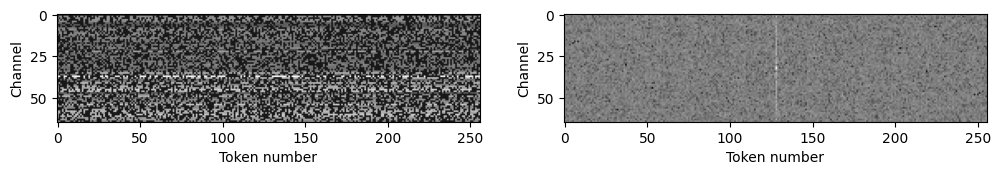

In [4]:
# Patch embeddings spectre visualization
IMG_SIZE = 32
PATCH_SIZE = 4
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

# Load test image
img = cv2.imread("data/test.jpg")
img = img.astype(np.float32)
img = img / 255.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).reshape((1, 1, img.shape[0], img.shape[1]))

patcher = PatchEmbedding(256, PATCH_SIZE, NUM_PATCHES, 0.5, 3)
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)
patches = patcher(img_tensor).squeeze()
print(patches.shape)
img_tensor = img_tensor.squeeze()

# Normal image
fig1, ax1 = plt.subplots(1, 2)
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 2))
#fig.set_figheight(15)
#fig.set_figwidth(15)
ax1[0].imshow(img)

# FFT of the image
fft_image = torch.fft.fftshift(torch.fft.fft2(img_tensor, dim=(-2, -1))).permute(1, 2, 0).cpu().numpy()
fft_image_np = np.fft.fftshift(np.fft.fft2(img))
patches_image = torch.fft.fftshift(torch.fft.fft2(patches, dim=(-2, -1))).detach().cpu().numpy()

fft_image = np.log(abs(fft_image))
fft_image_np = np.log(abs(fft_image_np))
patches_image = np.log(abs(patches_image))

fft_image = (fft_image - fft_image.min()) / (fft_image.max() - fft_image.min())
fft_image_np = (fft_image_np - fft_image_np.min()) / (fft_image_np.max() - fft_image_np.min())
patches_image = (patches_image - patches_image.min()) / (patches_image.max() - patches_image.min())

#ax[1].imshow(fft_image_np, cmap='gray')
ax1[1].imshow(fft_image, cmap='gray')
fig1.tight_layout()
fig1.savefig('image_example.png')

ax2[0].imshow(patches.detach().cpu().numpy(), cmap='gray')
ax2[0].set_ylabel("Channel")
ax2[0].set_xlabel("Token number")

ax2[1].imshow(patches_image, cmap='gray')
ax2[1].set_ylabel("Channel")
ax2[1].set_xlabel("Token number")

fig2.savefig('token_example.png')


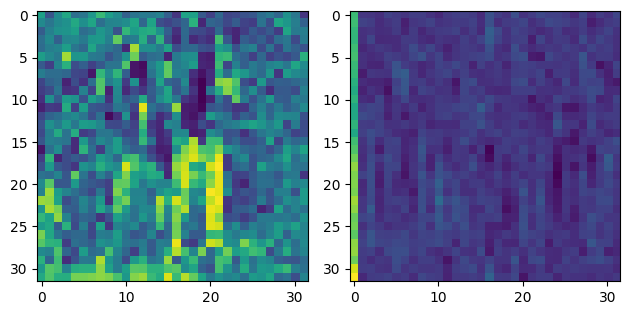

In [19]:
img = cv2.imread("data/test.jpg")
img = img.astype(np.float32)
img = img / 255.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

transform = transforms.Compose([
    transforms.ToTensor()
])
img_tensor = transform(img).cuda()
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.squeeze()

# Normal image
fig1, ax1 = plt.subplots(1, 2)
ax1[0].imshow(img)
hadamar_image = hadamard_transform(img_tensor)
hadamar_image = (hadamar_image - hadamar_image.min()) / (hadamar_image.max() - hadamar_image.min())

#ax[1].imshow(fft_image_np, cmap='gray')
ax1[1].imshow(hadamar_image.cpu().numpy().reshape(32, 32, 1))
fig1.tight_layout()